1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

2. Обучить модель на выбор из segmentation_models_pytorch

How to download dataset from kaggle to colab?
Thanks https://clck.ru/34zbjc

In [57]:
!pip install -q segmentation_models_pytorch
!pip install -q torchsummary
!pip install -q segmentation-models-pytorch

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
from torchsummary import summary
import torchvision

from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Linknet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch.utils as smp_utils

In [59]:
DATA_ROOT = './set-lipstick-original/'

In [60]:
!pip install -q kaggle

In [61]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [62]:
!kaggle datasets download olekslu/makeup-lips-segmentation-28k-samples

makeup-lips-segmentation-28k-samples.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip makeup-lips-segmentation-28k-samples.zip

(720, 1280, 3)


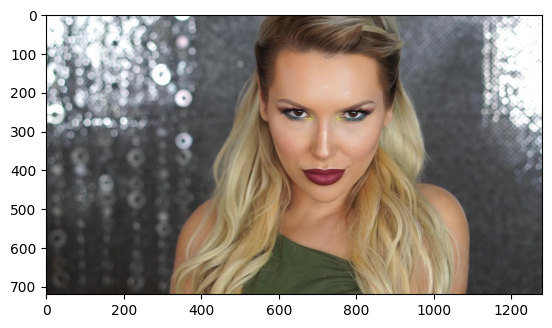

In [64]:
img = plt.imread(DATA_ROOT + '720p/image00000001.jpg')
print(img.shape)
plt.imshow(img);

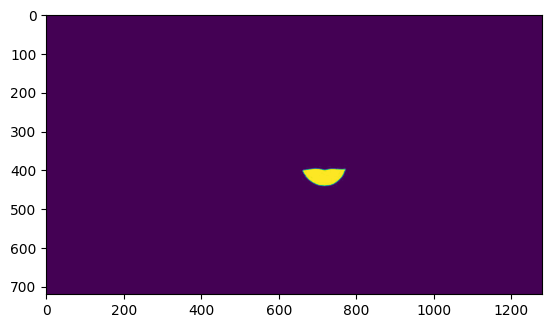

In [65]:
img = plt.imread(DATA_ROOT + 'mask/mask00000001.png')
plt.imshow(img[..., 1]);

In [66]:
df_images = pd.read_csv(DATA_ROOT + 'list.csv')
df_images.head()

filename  width  height class  xmin  ymin  xmax  ymax  \
0  image00000001.jpg   1280     720  Lips   661   394   776   444   
1  image00000002.jpg   1280     720  Lips   557   336   682   392   
2  image00000003.jpg   1280     720  Lips   553   369   684   427   
3  image00000004.jpg   1280     720  Lips   555   351   681   408   
4  image00000005.jpg   1280     720  Lips   555   351   680   407   

               mask  
0  mask00000001.png  
1  mask00000002.png  
2  mask00000003.png  
3  mask00000004.png  
4  mask00000005.png

In [67]:
df_images = df_images[['filename', 'mask']]
df_images.head()

filename              mask
0  image00000001.jpg  mask00000001.png
1  image00000002.jpg  mask00000002.png
2  image00000003.jpg  mask00000003.png
3  image00000004.jpg  mask00000004.png
4  image00000005.jpg  mask00000005.png

Проверяем, все ли картинки имеют маски

In [68]:
list_images = sorted([i for i in Path(DATA_ROOT + '720p').iterdir()])
list_masks = sorted([i for i in Path(DATA_ROOT + 'mask').iterdir()])
len(list_images), len(list_masks)

(28594, 28540)

Удаляем картинки, у которых нет маски

In [69]:
df_images = df_images.loc[df_images['mask'].isin([i.name for i in list_masks])]
df_images.reset_index(drop=True, inplace=True)
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


Подготавливаем класс для кастомного датасета. Для маски возьмём значение больше 10

In [70]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Serve our prepared dataframe
        self.data = data

        # Divide the dataframe into rgb images
        self.image_arr = self.data.iloc[:,0]
        # and segmented pictures
        self.label_arr = self.data.iloc[:,1]

        # Number of picture-segmentation pairs
        self.data_len = len(self.data.index)

        self.preprocessing = preprocessing


    def __getitem__(self, index):
        # Read the picture and immediately present it as a numpy array
        # size 600x800 float-values
        img = cv2.cvtColor(cv2.imread(DATA_ROOT + '720p/' + self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
           # Normalize the image in values [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)

        # read the segmented image
        mask = cv2.cvtColor(cv2.imread(DATA_ROOT + 'mask/' + self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]

        masks = torch.as_tensor(masks, dtype=torch.uint8)


        return (img.float(), masks)

    def __len__(self):
        return self.data_len

Инициализируем устройство

In [71]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Инициализируем Unet с предобученной Resnet50

In [72]:
BACKBONE = 'resnet50'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Создадим датасет, для препроцессинга мы будем использовать resnet50 обученную на imagenet

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


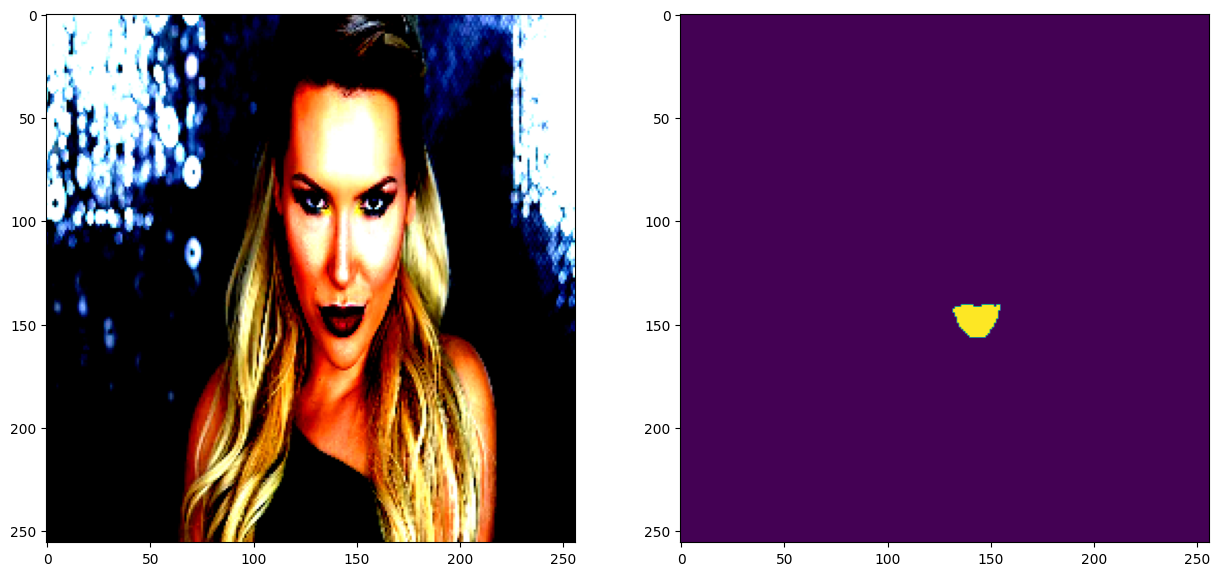

In [73]:
dataset = LipsDataset(df_images, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[:, :, 0])
plt.show()

Разделим выборку на обучающую и тестовую

In [74]:
X_train, X_test = train_test_split(df_images, test_size=0.3)

# Order indexing
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Wrap each fetch in our custom dataset
train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

Инициализируем Dataloader

In [75]:
train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False
)

Проверим диапазон значений в тензорах

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


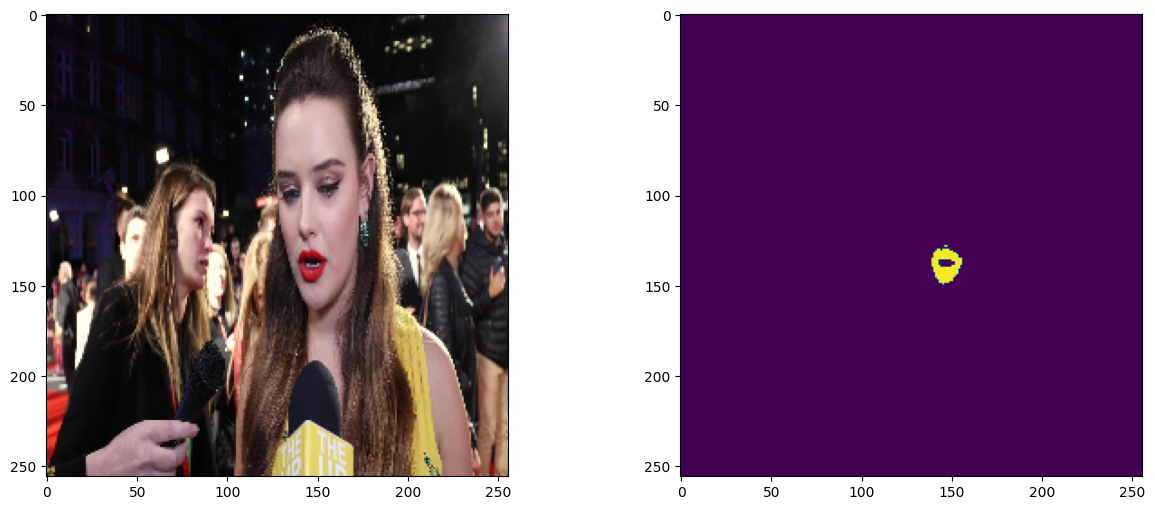

In [76]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [77]:
print(segmodel)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

Заморозим веса енкодера. Требование градиента выставим в False

In [78]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [79]:
summary(segmodel.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

9 млн. параметров нужно тренировать и почти 24 млн. нетренируемых

Инициализируем loss function, metric and optimizer с тренируемыми параметрами

In [80]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [81]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True,
)

# Тренировка модели

In [82]:
max_score = 0
for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1071/1071 [06:31<00:00,  2.74it/s, dice_loss - 0.034, iou_score - 0.9373]
Model saved!


In [84]:
data_iter = iter(train_data_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

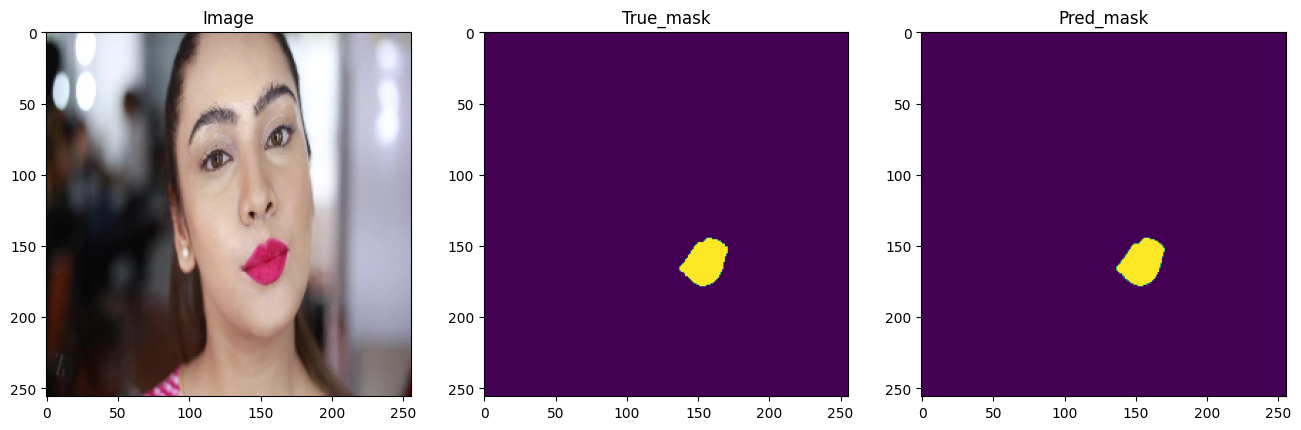

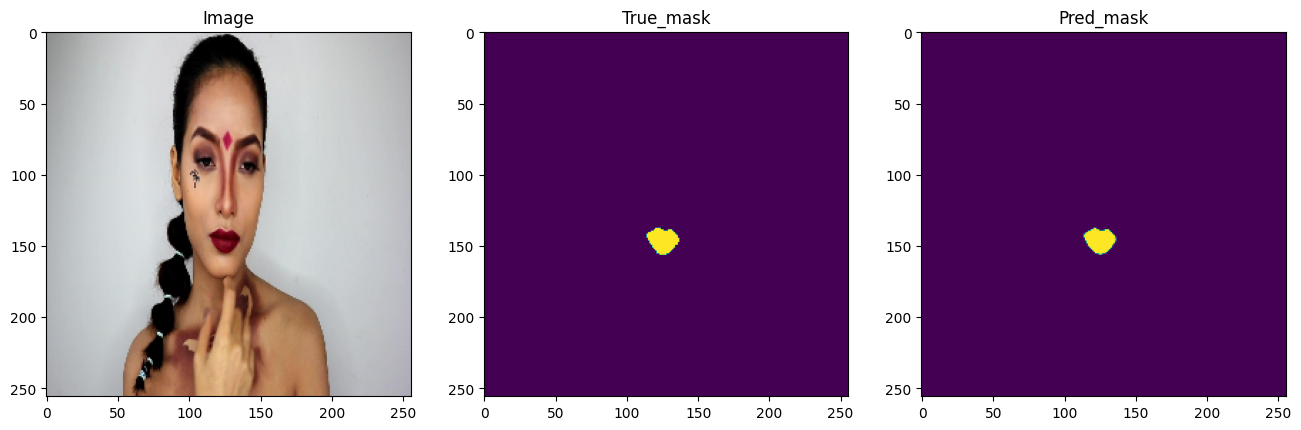

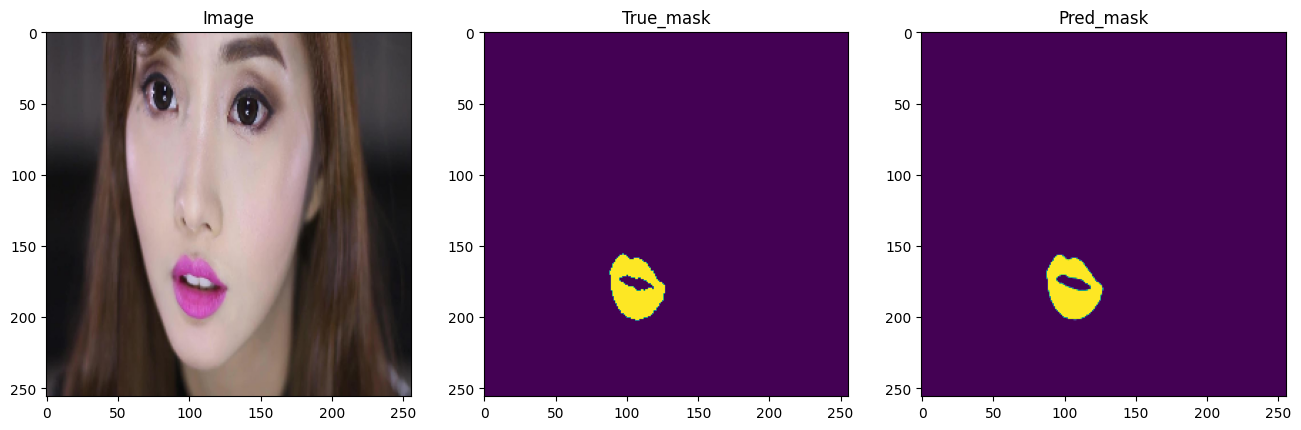

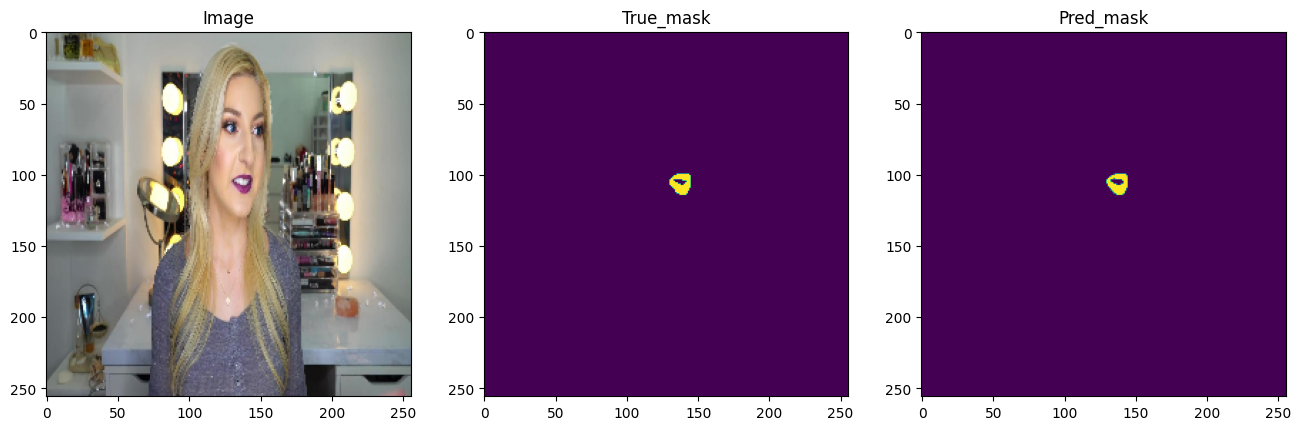

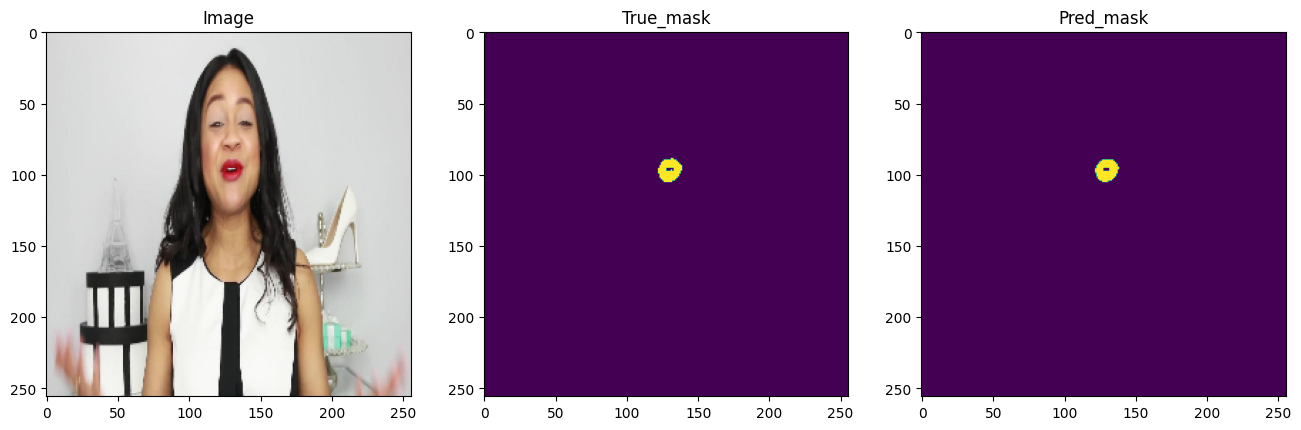

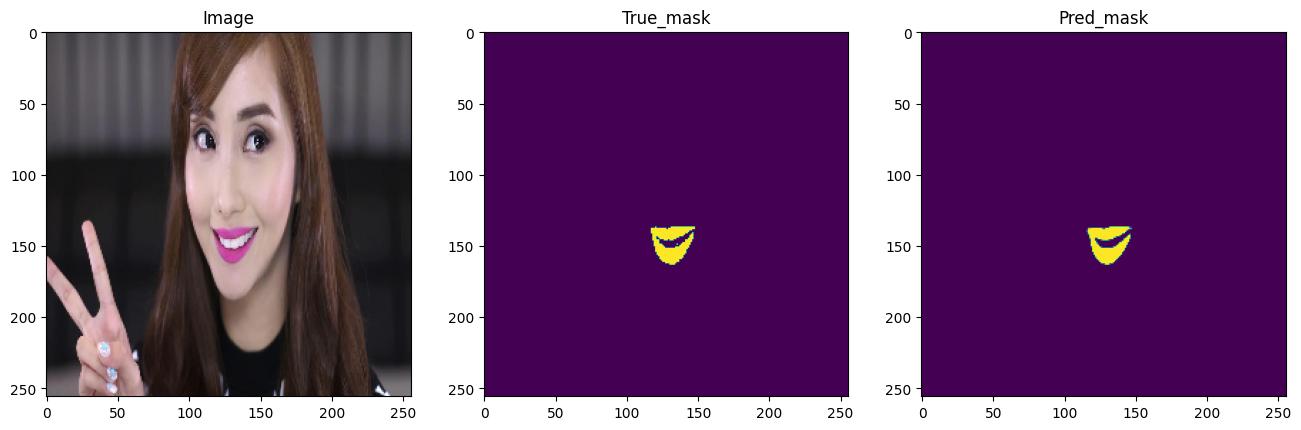

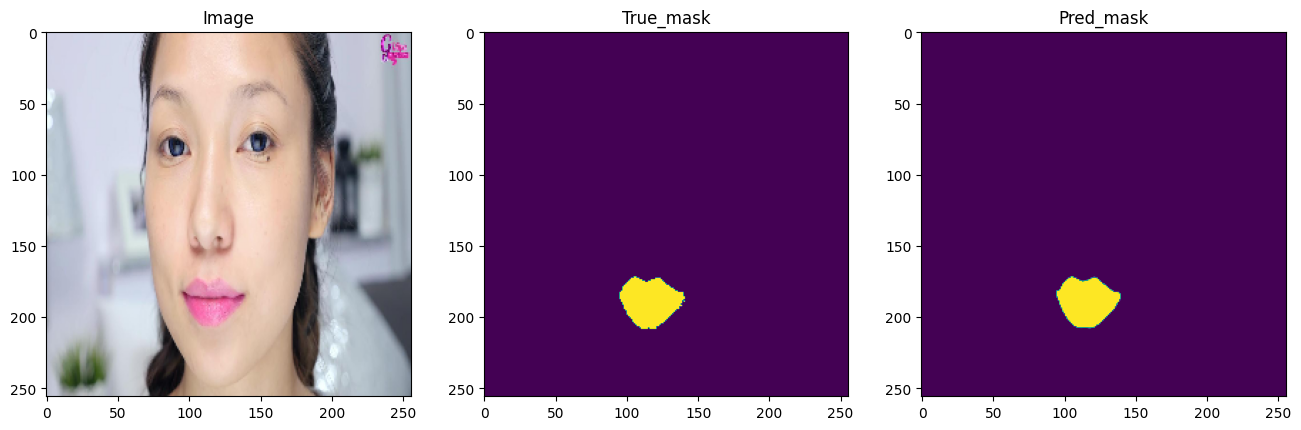

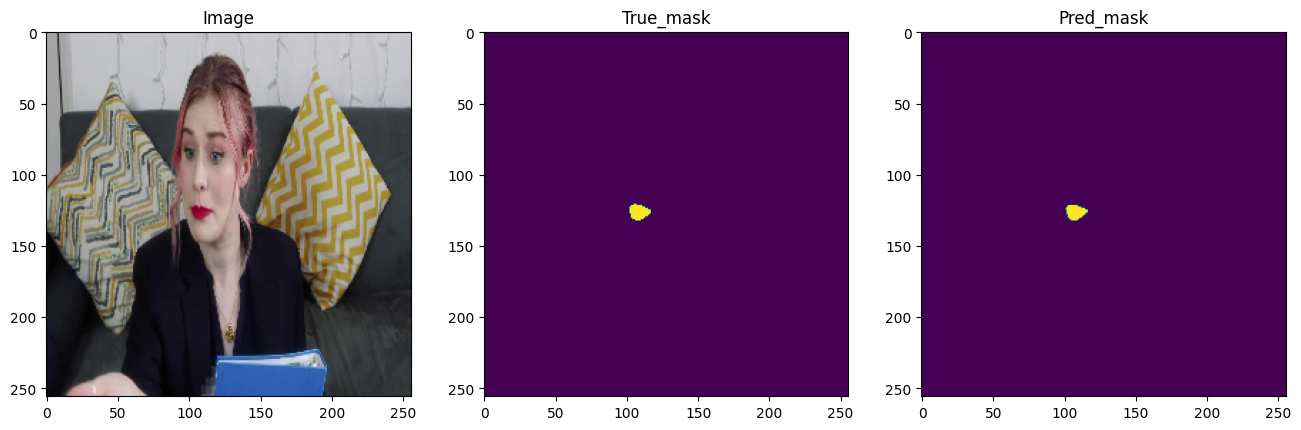

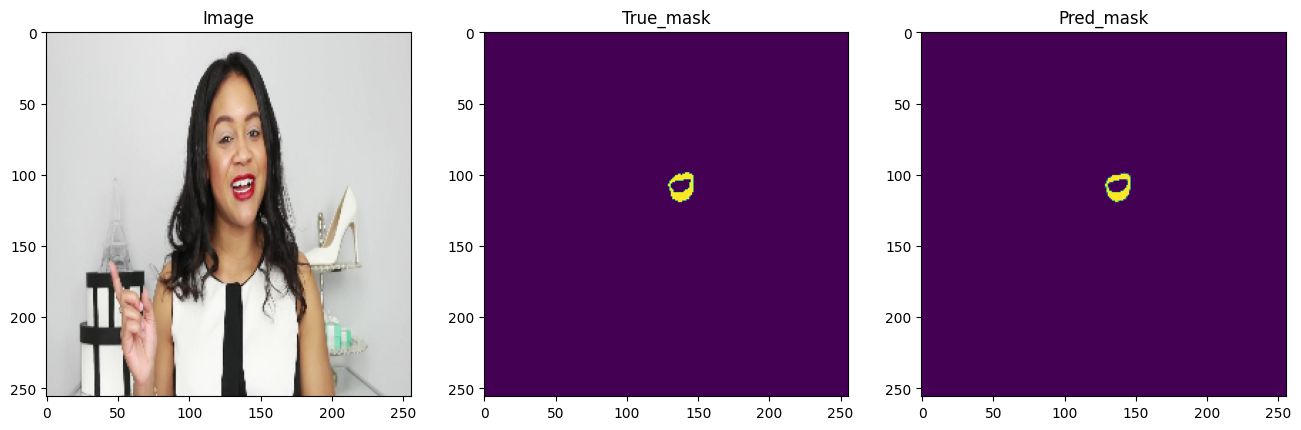

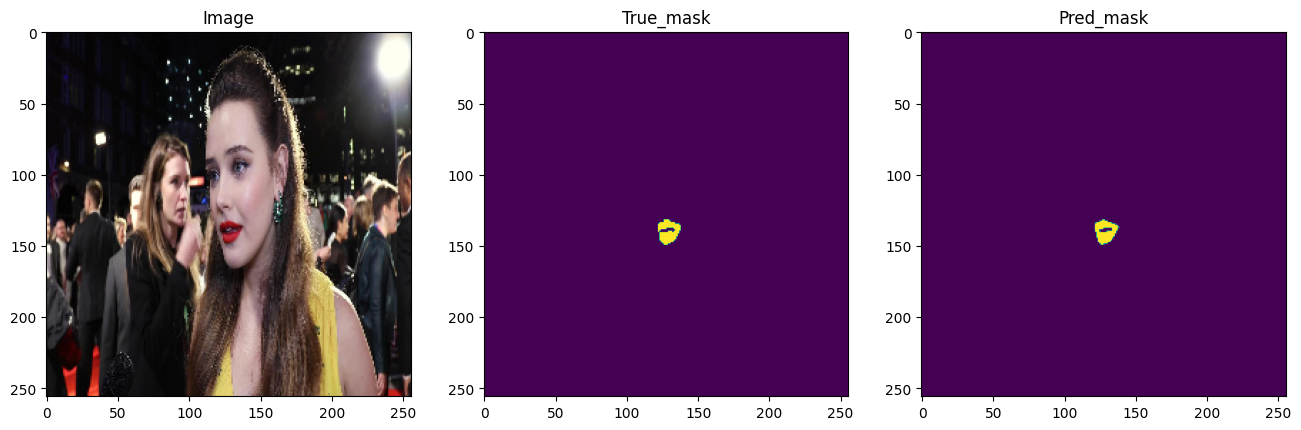

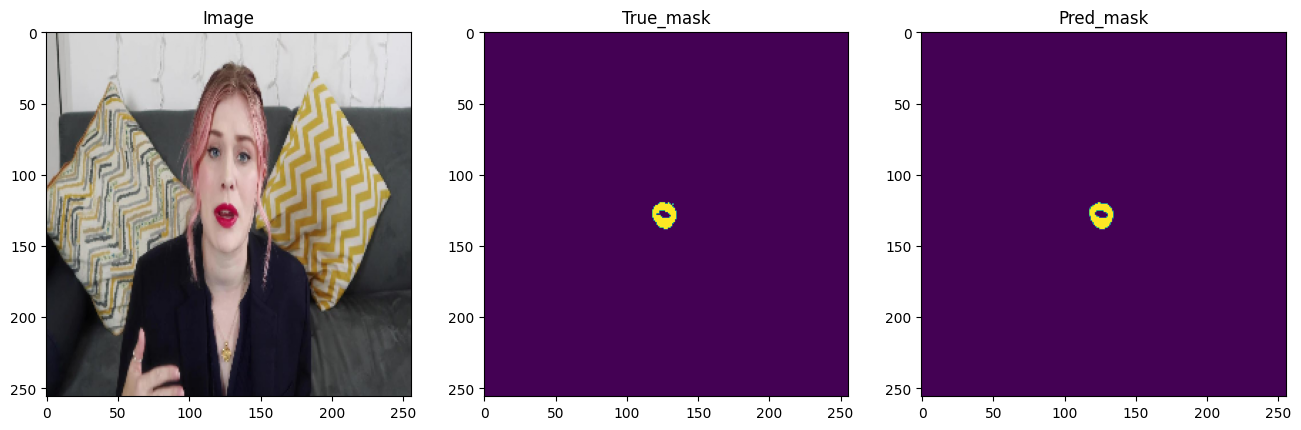

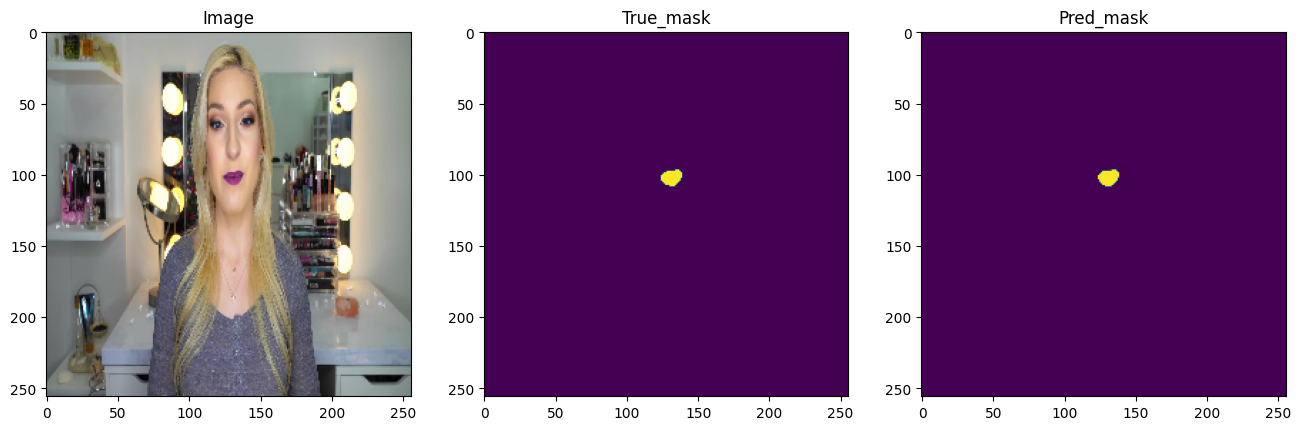

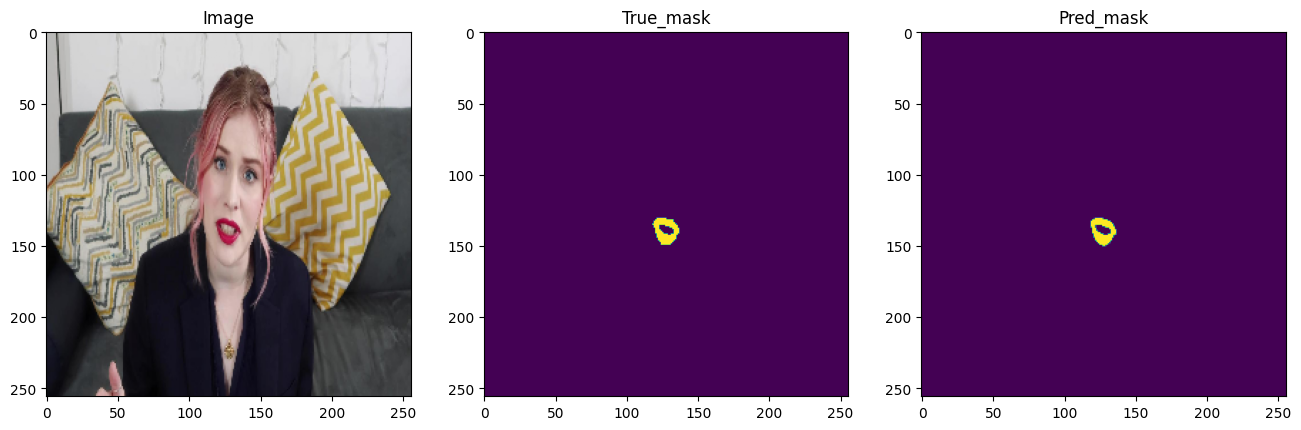

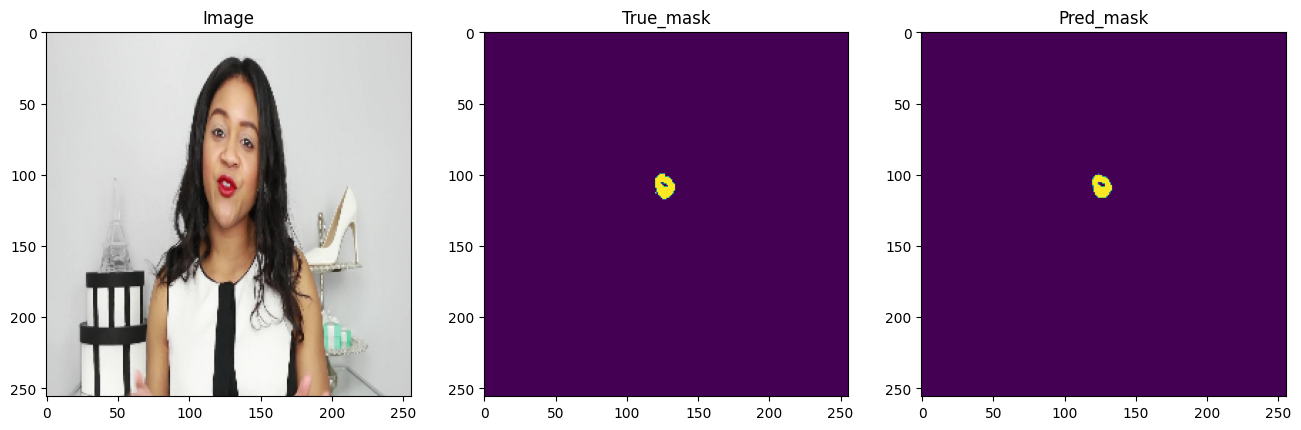

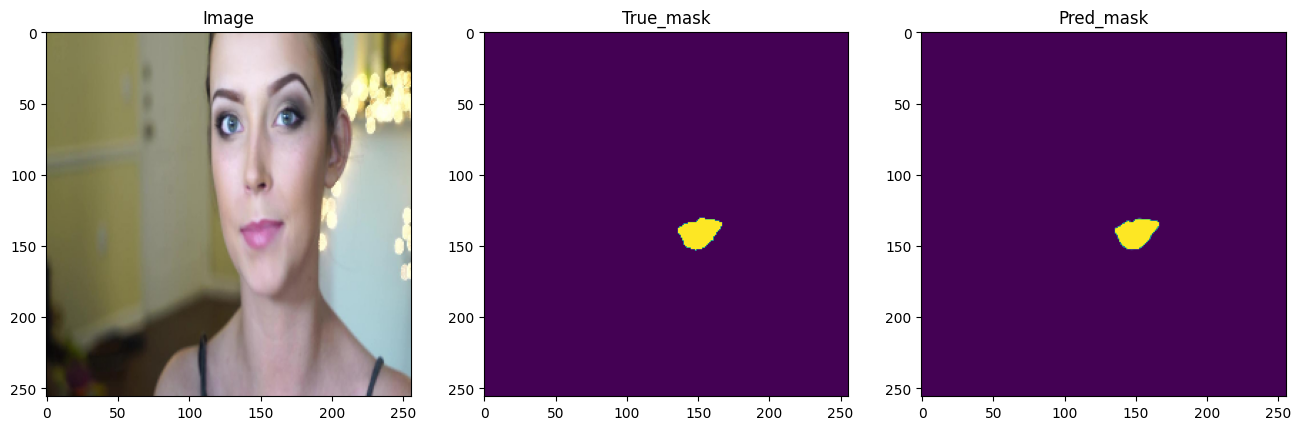

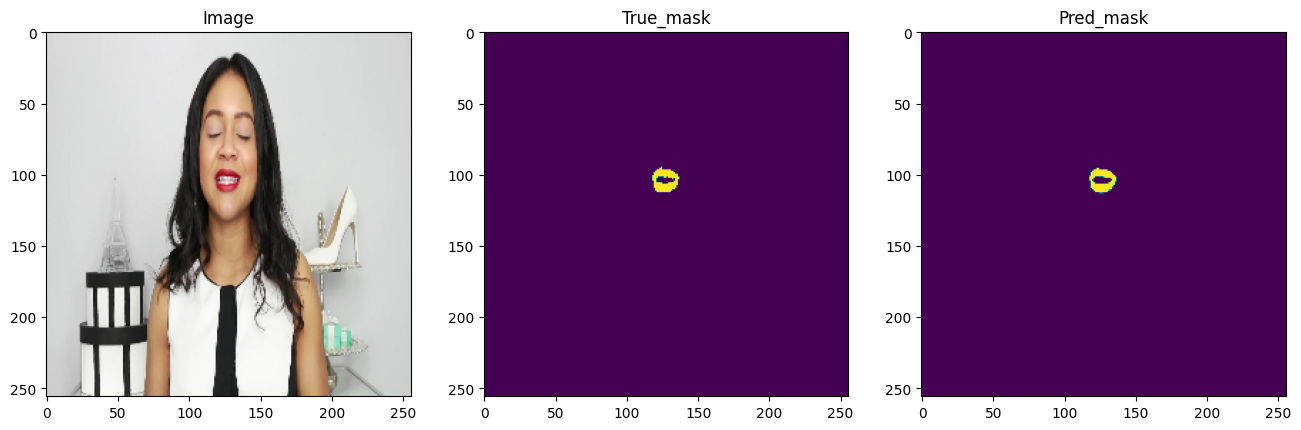

In [85]:
for i in range(images.shape[0]):

    fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))

    image = images[i].permute(1, 2, 0)

    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')

    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_2.set_title('True_mask')

    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('Pred_mask')